<h3> This notebook is a follow up of plasma_test_final.ipynb and serum_test_final.ipynb</h3>

<h1 style="background-color:#ff5200;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table Of Content</h1>



[1. Libraries And Utilities](#1)

[2 Processed Dataset from previous Notebook](#2)

[3 Models](#3)

[4. Visualization](#4)


<a id="1"></a>

<h1 style="background-color:#d8f8b7;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Libraries And Utilities</h1>

[Download DATASETS from here](https://github.com/utshabkg/LungCancer_Biomarker/tree/main/dataset)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report

from sklearn.model_selection import ShuffleSplit, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV
from yellowbrick.model_selection import FeatureImportances

<a id="2"></a>

<h1 style="background-color:#d8f8b7;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Processed Dataset from previous Notebook</h1>

[Download DATASETS from here](https://github.com/utshabkg/LungCancer_Biomarker/tree/main/dataset)

In [37]:
plasma = pd.read_csv('plasma(Specific Metabolics)_final.csv')
serum = pd.read_csv('serum(Specific Metabolics)_final.csv')
plasma.head()
plasma = plasma.drop('Unnamed: 0', axis=1)
serum = serum.drop('Unnamed: 0', axis=1)

In [38]:
plasma

,asparagine,benzoic acid,tryptophan,uric acid,alpha-ketoglutarate,citrulline,glutamine,malic acid,methionine sulfoxide,3-phosphoglycerate,...,aspartic acid,lactic acid,maltose,maltotriose,phenol,phosphoethanolamine,pyrophosphate,pyruvic acid,taurine,Class
0,-0.38,-1.31,0.52,-1.02,0.51,-0.33,-0.19,0.76,0.19,-0.49,...,0.02,-0.04,-0.34,-1.21,-0.10,0.03,-0.27,1.38,0.41,disease
1,0.95,-0.46,-0.90,-1.24,-0.39,0.69,1.04,0.09,-0.47,0.92,...,0.40,0.15,-0.29,-0.13,0.22,-0.83,-0.41,0.29,-0.16,disease
2,0.69,-0.49,0.83,-0.23,0.35,-0.56,0.36,0.06,-0.71,0.19,...,0.18,1.06,0.24,0.68,0.98,0.02,0.95,-0.19,0.83,disease
3,0.35,1.68,-1.11,-0.48,-0.75,-0.99,1.15,-0.41,-0.65,0.33,...,-0.35,0.53,-0.19,-0.38,0.69,-0.19,-0.59,-0.66,1.25,disease
4,0.30,-1.20,0.01,0.76,-0.14,0.77,-0.31,0.76,0.12,0.60,...,0.01,-0.33,-0.01,1.43,-0.27,0.32,0.52,-0.09,0.08,disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.77,-0.63,0.98,0.05,-0.30,0.08,1.06,-0.97,0.33,-0.89,...,-0.82,-0.72,-0.35,-0.38,-0.68,-0.45,-0.96,-0.12,-0.37,control
78,-0.43,-1.06,-0.03,1.56,-0.64,-0.41,-0.13,-0.67,-0.37,0.36,...,-0.73,0.64,-0.19,-0.60,0.79,-0.42,-0.22,-0.51,-0.23,control
79,-0.10,1.50,0.94,0.30,0.78,0.91,1.47,1.22,0.38,-0.47,...,-0.52,-0.53,-0.35,0.05,-0.44,-0.24,-0.67,-0.36,-0.54,control
80,-1.22,0.90,-1.34,-0.01,-0.14,-1.17,-1.39,-0.09,0.38,-0.78,...,-0.67,-0.46,-0.50,-0.83,-0.18,-0.44,-0.92,-0.10,-1.05,control


Keep labels as an numpy array.

In [39]:
labels = np.reshape(plasma.Class.to_numpy(), (82,1))
targets = plasma.iloc[:, -1].unique()

<a id="3"></a>

<h1 style="background-color:#d8f8b7;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Models</h1>

In [40]:
# !pip install lazypredict

In [41]:
def get_xy(df):
  X = df.drop('Class', axis=1)
  X = X.apply(pd.to_numeric)
  y = df['Class'].copy()
  y = y.map({"control": 0, "disease": 1})
  return X, y

In [55]:
full_result = []
accuracy = []
for k in [0]:
    if k==0:
        name = ['Serum(Specific Metabolics)']
        dfs = [serum]
    
    random_state = 42

    for idx, data in enumerate(dfs):
      result = []
      X, y = get_xy(data)
      rs = ShuffleSplit(n_splits=10, test_size=.2, random_state=random_state)
      raw_x = X
      for train_index, test_index in rs.split(X):
        clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=matthews_corrcoef, predictions=True)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        models, predictions = clf.fit(X_train, X_test, y_train, y_test)
        result.append(models)

      acc = []
      for i in range(1):
        acc.append(result[i].iloc[0]['Balanced Accuracy'])

#       print(f'\n{name[idx]}: {sum(acc)/len(acc)}')
#       accuracy.append([f'{name[idx]}', f'{sum(acc)/len(acc)}'])
        
      full_result.append(result)

100%|██████████| 29/29 [00:00<00:00, 53.67it/s]


In [43]:
# full_result

In [44]:
# full_result[0][0]

In [45]:
model_names = full_result[0][0].index
# model_names

In [56]:
model_topper = {}
for i in model_names:
    vars()[i] = [0, 0.0]
    model_topper[i] = vars()[i]
for i in range(1):
    for j in range(len(model_names)):
        if full_result[0][i].index[0] == model_names[j]:
            vars()[model_names[j]][0] += 1
        vars()[model_names[j]][1] += full_result[0][i].loc[model_names[j]]['Balanced Accuracy']
        model_topper[model_names[j]] = vars()[model_names[j]]

model_topper

{'AdaBoostClassifier': [0, 0.7348484848484849],
 'BaggingClassifier': [0, 0.7424242424242424],
 'BernoulliNB': [0, 0.696969696969697],
 'CalibratedClassifierCV': [0, 0.7803030303030303],
 'DecisionTreeClassifier': [0, 0.7803030303030303],
 'DummyClassifier': [0, 0.606060606060606],
 'ExtraTreeClassifier': [0, 0.6893939393939394],
 'ExtraTreesClassifier': [0, 0.7803030303030303],
 'GaussianNB': [0, 0.7727272727272727],
 'KNeighborsClassifier': [0, 0.7348484848484849],
 'LGBMClassifier': [0, 0.696969696969697],
 'LabelPropagation': [0, 0.6515151515151515],
 'LabelSpreading': [0, 0.6515151515151515],
 'LinearDiscriminantAnalysis': [0, 0.7348484848484849],
 'LinearSVC': [0, 0.696969696969697],
 'LogisticRegression': [0, 0.696969696969697],
 'NearestCentroid': [0, 0.6515151515151515],
 'NuSVC': [0, 0.7424242424242424],
 'PassiveAggressiveClassifier': [0, 0.6515151515151515],
 'Perceptron': [0, 0.7348484848484849],
 'QuadraticDiscriminantAnalysis': [0, 0.6515151515151515],
 'RandomForestClas

In [57]:
full_result[0][0].iloc[0]['Balanced Accuracy']

0.7803030303030303

In [48]:
# necessary functions
labels = np.reshape(plasma['Class'].to_numpy(), (82,1))

def pca_analysis(df, n_components):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(df.iloc[:, :-1].values)

    pca_concatenate = np.concatenate([pca_result, labels], axis=1)
    return pca_concatenate

def make_dataframe(array, n_features):
    col = []
    for i in range(1, n_features+1):
        col.append(f'pc{i}')
    col.append('Class')
    return pd.DataFrame(array, columns = col)

def tsne_analysis(df, n_components):
    tsne = TSNE(n_components=n_components)
    tsne_result = tsne.fit_transform(df.iloc[:, :-1].values)

    tsne_concatenate = np.concatenate([tsne_result, labels], axis=1)
    return tsne_concatenate
def tsne_dataframe(array, n_features):
    col = []
    for i in range(1, n_features+1):
        col.append(f'tsne{i}')
    col.append('Class')
    return pd.DataFrame(array, columns = col)

def get_xy(df):
  X = df.drop('Class', axis=1)
  X = X.apply(pd.to_numeric)
  y = df['Class'].copy()
  y = y.map({"control": 0, "disease": 1})
  return X, y

In [51]:
accuracy = []
for k in [0, 2, 3, 4, 5, 22, 23]:
    
    if k==0:
        name = ['Plasma(Raw)', 'Serum(Raw)', 'Plasma(Exploratory)', 'Serum(Exploratory)']
        dfs = [plasma, serum]
    
    elif k==22 or k==23:
        k -= 20
        name = [f'tsne{k}_plasma(Exploratory)', f'tsne{k}_serum(Exploratory)']
        vars()[f'tsne{k}_plasma'] = tsne_analysis(plasma, k)
        vars()[f'tsne{k}_plasma_df'] = make_dataframe(vars()[f'tsne{k}_plasma'], k)
        
        vars()[f'tsne{k}_serum'] = pca_analysis(serum, k)
        vars()[f'tsne{k}_serum_df'] = make_dataframe(vars()[f'tsne{k}_serum'], k)
        
        dfs = [vars()[f'tsne{k}_plasma_df'], vars()[f'tsne{k}_serum_df']]
    
    else:
        name = [f'pca{k}_plasma(Exploratory)', f'pca{k}_serum(Exploratory)']
        vars()[f'pca{k}_plasma'] = pca_analysis(plasma, k)
        vars()[f'pca{k}_plasma_df'] = make_dataframe(vars()[f'pca{k}_plasma'], k)
        
        vars()[f'pca{k}_serum'] = pca_analysis(serum, k)
        vars()[f'pca{k}_serum_df'] = make_dataframe(vars()[f'pca{k}_serum'], k)
        
        dfs = [vars()[f'pca{k}_plasma_df'], vars()[f'pca{k}_serum_df']]
    
    random_state = 42

    for idx, data in enumerate(dfs):
        result = []
        if data.columns[-1]=='Class':
            X = data.drop('Class', axis=1)
        else:
            X = data
        y = plasma['Class'].copy()
        y = y.map({"control": 0, "disease": 1})
        rs = ShuffleSplit(n_splits=10, test_size=.2, random_state=random_state)

        for train_index, test_index in rs.split(X):
            clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=matthews_corrcoef, predictions=True)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            scaler = RobustScaler()

            cols = X_train.columns
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            X_train = pd.DataFrame(X_train, columns=[cols])
            X_test = pd.DataFrame(X_test, columns=[cols])

            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            result.append(models)
        #     print(result)

        acc = []
        for i in range(1):
            for j in range(len(model_names)):
                if result[i].index[j] == 'RidgeClassifier':
                    acc.append(result[i].loc['RidgeClassifier']['Balanced Accuracy'])
#                     print(result[i].index[j], result[i].iloc[j]['Balanced Accuracy'])

        print(f'\n{name[idx]}: {sum(acc)/len(acc)}')
        accuracy.append([f'{name[idx]}', f'{sum(acc)/len(acc)}'])

accuracy_df1 = pd.DataFrame(accuracy, columns=['Processed Dataset', 'Accuracy'])
accuracy_df1

  7%|▋         | 2/29 [00:00<00:01, 19.36it/s]


Plasma(Raw): 0.9090909090909092


  7%|▋         | 2/29 [00:00<00:01, 19.05it/s]


Serum(Raw): 0.7348484848484849


  7%|▋         | 2/29 [00:00<00:01, 18.42it/s]


pca2_plasma(Exploratory): 0.8181818181818181


  7%|▋         | 2/29 [00:00<00:01, 15.87it/s]


pca2_serum(Exploratory): 0.6515151515151515


  7%|▋         | 2/29 [00:00<00:01, 17.05it/s]


pca3_plasma(Exploratory): 0.8181818181818181


  7%|▋         | 2/29 [00:00<00:01, 18.02it/s]


pca3_serum(Exploratory): 0.6515151515151515


  7%|▋         | 2/29 [00:00<00:01, 15.39it/s]


pca4_plasma(Exploratory): 0.8181818181818181


 10%|█         | 3/29 [00:00<00:01, 25.48it/s]


pca4_serum(Exploratory): 0.6515151515151515


 10%|█         | 3/29 [00:00<00:00, 26.46it/s]


pca5_plasma(Exploratory): 0.8181818181818181


100%|██████████| 29/29 [00:00<00:00, 51.07it/s]



pca5_serum(Exploratory): 0.6515151515151515


 14%|█▍        | 4/29 [00:00<00:00, 34.66it/s]


tsne2_plasma(Exploratory): 0.8636363636363636


100%|██████████| 29/29 [00:00<00:00, 48.58it/s]



tsne2_serum(Exploratory): 0.6515151515151515


  7%|▋         | 2/29 [00:00<00:01, 16.80it/s]


tsne3_plasma(Exploratory): 0.5984848484848485


100%|██████████| 29/29 [00:00<00:00, 49.43it/s]


tsne3_serum(Exploratory): 0.6515151515151515


,Processed Dataset,Accuracy
0,Plasma(Raw),0.9090909090909092
1,Serum(Raw),0.7348484848484849
2,pca2_plasma(Exploratory),0.8181818181818181
3,pca2_serum(Exploratory),0.6515151515151515
4,pca3_plasma(Exploratory),0.8181818181818181
5,pca3_serum(Exploratory),0.6515151515151515
6,pca4_plasma(Exploratory),0.8181818181818181
7,pca4_serum(Exploratory),0.6515151515151515
8,pca5_plasma(Exploratory),0.8181818181818181
9,pca5_serum(Exploratory),0.6515151515151515


In [52]:
accuracy = []
for k in [0, 2, 3, 4, 5, 22, 23]:
    
    if k==0:
        name = ['Plasma(Raw)', 'Serum(Raw)', 'Plasma(Exploratory)', 'Serum(Exploratory)']
        dfs = [plasma, serum]
    
    elif k==22 or k==23:
        k -= 20
        name = [f'tsne{k}_plasma(Exploratory)', f'tsne{k}_serum(Exploratory)']
        vars()[f'tsne{k}_plasma'] = tsne_analysis(plasma, k)
        vars()[f'tsne{k}_plasma_df'] = make_dataframe(vars()[f'tsne{k}_plasma'], k)
        
        vars()[f'tsne{k}_serum'] = pca_analysis(serum, k)
        vars()[f'tsne{k}_serum_df'] = make_dataframe(vars()[f'tsne{k}_serum'], k)
        
        dfs = [vars()[f'tsne{k}_plasma_df'], vars()[f'tsne{k}_serum_df']]
    
    else:
        name = [f'pca{k}_plasma(Exploratory)', f'pca{k}_serum(Exploratory)']
        vars()[f'pca{k}_plasma'] = pca_analysis(plasma, k)
        vars()[f'pca{k}_plasma_df'] = make_dataframe(vars()[f'pca{k}_plasma'], k)
        
        vars()[f'pca{k}_serum'] = pca_analysis(serum, k)
        vars()[f'pca{k}_serum_df'] = make_dataframe(vars()[f'pca{k}_serum'], k)
        
        dfs = [vars()[f'pca{k}_plasma_df'], vars()[f'pca{k}_serum_df']]
    
    random_state = 42

    for idx, data in enumerate(dfs):
        result = []
        if data.columns[-1]=='Class':
            X = data.drop('Class', axis=1)
        else:
            X = data
        y = plasma['Class'].copy()
        y = y.map({"control": 0, "disease": 1})
        rs = ShuffleSplit(n_splits=10, test_size=.2, random_state=random_state)

        for train_index, test_index in rs.split(X):
            clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=matthews_corrcoef, predictions=True)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            scaler = RobustScaler()

            cols = X_train.columns
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            X_train = pd.DataFrame(X_train, columns=[cols])
            X_test = pd.DataFrame(X_test, columns=[cols])

            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            result.append(models)
        #     print(result)

        acc = []
        for i in range(1):
            for j in range(len(model_names)):
                if result[i].index[j] == 'RandomForestClassifier':
                    acc.append(result[i].loc['RandomForestClassifier']['Balanced Accuracy'])
#                     print(result[i].index[j], result[i].iloc[j]['Balanced Accuracy'])

        print(f'\n{name[idx]}: {sum(acc)/len(acc)}')
        accuracy.append([f'{name[idx]}', f'{sum(acc)/len(acc)}'])

accuracy_df2 = pd.DataFrame(accuracy, columns=['Processed Dataset', 'Accuracy'])
accuracy_df2

  7%|▋         | 2/29 [00:00<00:01, 18.72it/s]


Plasma(Raw): 0.8712121212121212


  7%|▋         | 2/29 [00:00<00:01, 19.23it/s]


Serum(Raw): 0.7803030303030303


  7%|▋         | 2/29 [00:00<00:01, 19.47it/s]


pca2_plasma(Exploratory): 0.8712121212121212


  7%|▋         | 2/29 [00:00<00:01, 16.98it/s]


pca2_serum(Exploratory): 0.7878787878787878


  7%|▋         | 2/29 [00:00<00:01, 18.66it/s]


pca3_plasma(Exploratory): 0.8257575757575758


 10%|█         | 3/29 [00:00<00:00, 27.33it/s]


pca3_serum(Exploratory): 0.8636363636363636


  7%|▋         | 2/29 [00:00<00:01, 18.80it/s]


pca4_plasma(Exploratory): 0.8712121212121212


  7%|▋         | 2/29 [00:00<00:01, 18.70it/s]


pca4_serum(Exploratory): 0.7803030303030303


  7%|▋         | 2/29 [00:00<00:01, 18.97it/s]


pca5_plasma(Exploratory): 0.8712121212121212


100%|██████████| 29/29 [00:00<00:00, 49.00it/s]



pca5_serum(Exploratory): 0.7878787878787878


  7%|▋         | 2/29 [00:00<00:01, 19.38it/s]


tsne2_plasma(Exploratory): 0.7803030303030303


100%|██████████| 29/29 [00:00<00:00, 50.04it/s]



tsne2_serum(Exploratory): 0.7878787878787878


  3%|▎         | 1/29 [00:00<00:02,  9.43it/s]


tsne3_plasma(Exploratory): 0.5606060606060606


100%|██████████| 29/29 [00:00<00:00, 49.22it/s]


tsne3_serum(Exploratory): 0.8636363636363636


,Processed Dataset,Accuracy
0,Plasma(Raw),0.8712121212121212
1,Serum(Raw),0.7803030303030303
2,pca2_plasma(Exploratory),0.8712121212121212
3,pca2_serum(Exploratory),0.7878787878787878
4,pca3_plasma(Exploratory),0.8257575757575758
5,pca3_serum(Exploratory),0.8636363636363636
6,pca4_plasma(Exploratory),0.8712121212121212
7,pca4_serum(Exploratory),0.7803030303030303
8,pca5_plasma(Exploratory),0.8712121212121212
9,pca5_serum(Exploratory),0.7878787878787878


In [54]:
accuracy = []
for k in [0, 2, 3, 4, 5, 22, 23]:
    
    if k==0:
        name = ['Plasma(Raw)', 'Serum(Raw)', 'Plasma(Exploratory)', 'Serum(Exploratory)']
        dfs = [plasma, serum]
    
    elif k==22 or k==23:
        k -= 20
        name = [f'tsne{k}_plasma(Exploratory)', f'tsne{k}_serum(Exploratory)']
        vars()[f'tsne{k}_plasma'] = tsne_analysis(plasma, k)
        vars()[f'tsne{k}_plasma_df'] = make_dataframe(vars()[f'tsne{k}_plasma'], k)
        
        vars()[f'tsne{k}_serum'] = pca_analysis(serum, k)
        vars()[f'tsne{k}_serum_df'] = make_dataframe(vars()[f'tsne{k}_serum'], k)
        
        dfs = [vars()[f'tsne{k}_plasma_df'], vars()[f'tsne{k}_serum_df']]
    
    else:
        name = [f'pca{k}_plasma(Exploratory)', f'pca{k}_serum(Exploratory)']
        vars()[f'pca{k}_plasma'] = pca_analysis(plasma, k)
        vars()[f'pca{k}_plasma_df'] = make_dataframe(vars()[f'pca{k}_plasma'], k)
        
        vars()[f'pca{k}_serum'] = pca_analysis(serum, k)
        vars()[f'pca{k}_serum_df'] = make_dataframe(vars()[f'pca{k}_serum'], k)
        
        dfs = [vars()[f'pca{k}_plasma_df'], vars()[f'pca{k}_serum_df']]
    
    random_state = 42

    for idx, data in enumerate(dfs):
        result = []
        if data.columns[-1]=='Class':
            X = data.drop('Class', axis=1)
        else:
            X = data
        y = plasma['Class'].copy()
        y = y.map({"control": 0, "disease": 1})
        rs = ShuffleSplit(n_splits=10, test_size=.2, random_state=random_state)

        for train_index, test_index in rs.split(X):
            clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=matthews_corrcoef, predictions=True)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            scaler = RobustScaler()

            cols = X_train.columns
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            X_train = pd.DataFrame(X_train, columns=[cols])
            X_test = pd.DataFrame(X_test, columns=[cols])

            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            result.append(models)
        #     print(result)

        acc = []
        for i in range(1):
            for j in range(len(model_names)):
                if result[i].index[j] == 'XGBClassifier':
                    acc.append(result[i].loc['XGBClassifier']['Balanced Accuracy'])
#                     print(result[i].index[j], result[i].iloc[j]['Balanced Accuracy'])

        print(f'\n{name[idx]}: {sum(acc)/len(acc)}')
        accuracy.append([f'{name[idx]}', f'{sum(acc)/len(acc)}'])
        
accuracy_df3 = pd.DataFrame(accuracy, columns=['Processed Dataset', 'Accuracy'])
accuracy_df3

  7%|▋         | 2/29 [00:00<00:01, 18.14it/s]


Plasma(Raw): 0.7045454545454546


  7%|▋         | 2/29 [00:00<00:01, 17.30it/s]


Serum(Raw): 0.7803030303030303


 10%|█         | 3/29 [00:00<00:00, 26.72it/s]


pca2_plasma(Exploratory): 0.8712121212121212


  7%|▋         | 2/29 [00:00<00:01, 19.03it/s]


pca2_serum(Exploratory): 0.696969696969697


 10%|█         | 3/29 [00:00<00:00, 27.58it/s]


pca3_plasma(Exploratory): 0.8712121212121212


  7%|▋         | 2/29 [00:00<00:01, 17.09it/s]


pca3_serum(Exploratory): 0.8636363636363636


  7%|▋         | 2/29 [00:00<00:01, 17.53it/s]


pca4_plasma(Exploratory): 0.8712121212121212


 10%|█         | 3/29 [00:00<00:00, 27.14it/s]


pca4_serum(Exploratory): 0.8636363636363636


  7%|▋         | 2/29 [00:00<00:01, 17.91it/s]


pca5_plasma(Exploratory): 0.8712121212121212


100%|██████████| 29/29 [00:00<00:00, 47.72it/s]



pca5_serum(Exploratory): 0.7424242424242424


  7%|▋         | 2/29 [00:00<00:01, 16.79it/s]


tsne2_plasma(Exploratory): 0.8257575757575758


100%|██████████| 29/29 [00:00<00:00, 49.22it/s]



tsne2_serum(Exploratory): 0.696969696969697


  7%|▋         | 2/29 [00:00<00:01, 19.33it/s]


tsne3_plasma(Exploratory): 0.7045454545454546


100%|██████████| 29/29 [00:00<00:00, 48.90it/s]


tsne3_serum(Exploratory): 0.8636363636363636


,Processed Dataset,Accuracy
0,Plasma(Raw),0.7045454545454546
1,Serum(Raw),0.7803030303030303
2,pca2_plasma(Exploratory),0.8712121212121212
3,pca2_serum(Exploratory),0.696969696969697
4,pca3_plasma(Exploratory),0.8712121212121212
5,pca3_serum(Exploratory),0.8636363636363636
6,pca4_plasma(Exploratory),0.8712121212121212
7,pca4_serum(Exploratory),0.8636363636363636
8,pca5_plasma(Exploratory),0.8712121212121212
9,pca5_serum(Exploratory),0.7424242424242424


In [61]:
accuracy_df = pd.DataFrame({
    'Method': ['Ridge Classifier (Without PCA)', 'Ridge Classifier (With PCA)', 'Random Forest Classifier (Without PCA)', 'Random Forest Classifier (With PCA)'],
    'Accuracy': [90.91, 81.82, 78.03, 86.36]
})
accuracy_df

,Method,Accuracy
0,Ridge Classifier (Without PCA),90.91
1,Ridge Classifier (With PCA),81.82
2,Random Forest Classifier (Without PCA),78.03
3,Random Forest Classifier (With PCA),86.36


In [62]:
accuracy_df.to_csv('G:/Research/SM Sir/LungCancer_Biomarker/final and best approach/accuracy_1+2.csv', index=False)

<a id="4"></a>

<h1 style="background-color:#d8f8b7;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Visualization</h1>

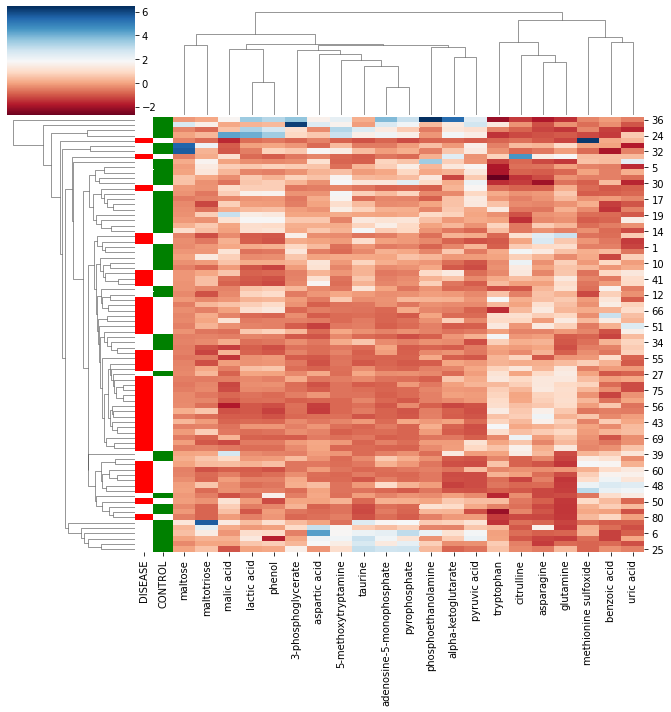

In [97]:
# Data set
final_df1 = plasma.copy()
Class = plasma.pop("Class")
# final_df = final_df.set_index('Metabolics')

lut = dict(zip(Class.unique(), "grb"))
row_colors = Class.map(lut)
df_colors = pd.DataFrame(data={'DISEASE': row_colors[row_colors == 'r'], 'CONTROL': row_colors[row_colors == 'g']}) 
# Default plot
g = sns.clustermap(plasma, cmap='RdBu', row_colors=df_colors, z_score=1)      #z_score->standardize; standard_cale->normalize
g.fig.subplots_adjust(right=0.9)
g.ax_cbar.set_position((0.7, .2, .03, .4), 'horizontal')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
# Show the graph
# Show the graph
plt.savefig('plotting/clustermap_plasma_final.JPG')
plt.show()

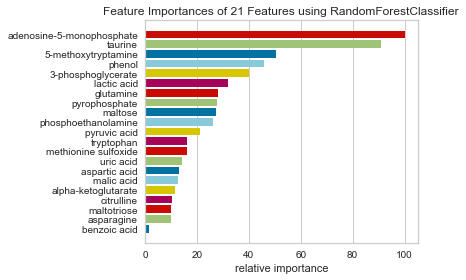

<AxesSubplot:title={'center':'Feature Importances of 21 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [131]:
# Load the classification data set
X = final_df1.iloc[:, :-1]
y = final_df1['Class'].copy()
y = y.map({"control": 1, "disease": 0})

model = RandomForestClassifier(n_estimators=17)
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()

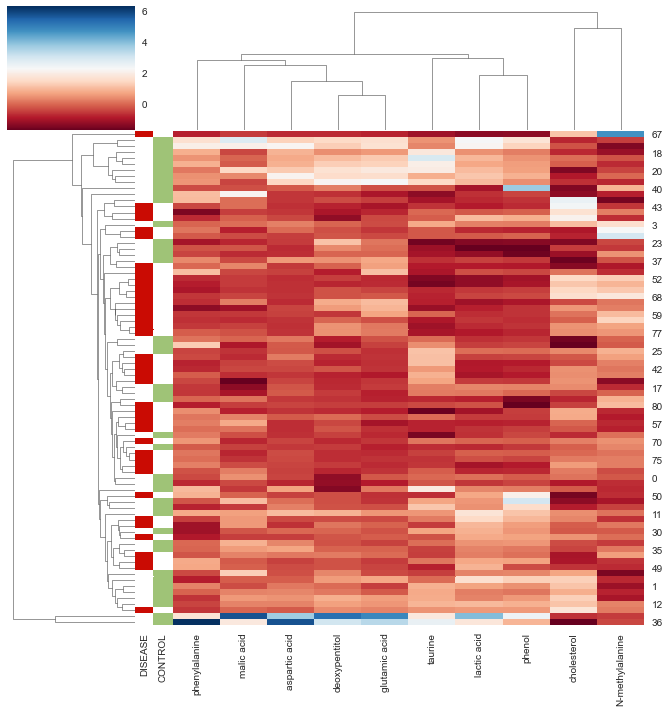

In [136]:
# Data set
final_df2 = serum.iloc[:, :-1]
Class = y
# final_df = final_df.set_index('Metabolics')

lut = dict(zip(Class.unique(), "grb"))
row_colors = Class.map(lut)
df_colors = pd.DataFrame(data={'DISEASE': row_colors[row_colors == 'r'], 'CONTROL': row_colors[row_colors == 'g']}) 
# Default plot
g = sns.clustermap(final_df2, cmap='RdBu', row_colors=df_colors, z_score=1)      #z_score->standardize; standard_cale->normalize
g.fig.subplots_adjust(right=0.9)
g.ax_cbar.set_position((0.7, .2, .03, .4), 'horizontal')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
# Show the graph
# Show the graph
plt.savefig('plotting/clustermap_serum_final.JPG')
plt.show()

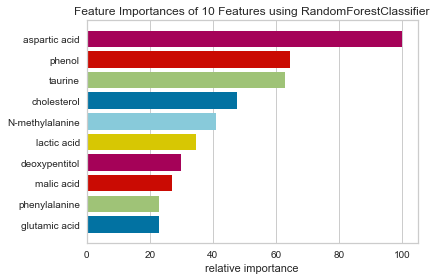

<AxesSubplot:title={'center':'Feature Importances of 10 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [137]:
# Load the classification data set
X = final_df2
y = Class
model = RandomForestClassifier(n_estimators=17)
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()